<br>
# Economic Impact of Coronavirus<br>

## By Dennis Tsarkov

As the title says, in this project I will attempt to analyze the impact the Novel Cornavirus (2019-nCoV) has had on the world economy.

First I'm going to import the yfinance library to get market data from Yahoo Finance.

In [9]:
import yfinance as yf

And the libaries I will need for graphing, as well as some design setting to make everything look nice.

In [10]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as plticker

import pandas as pd
pd.plotting.register_matplotlib_converters()

from datetime import datetime

plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = 7.5, 5
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['legend.fontsize'] = 14

And last, but not least, a function to deal with the some quirks of plotting dates.

In [11]:
def setTicks(ax,data,dist,zero):
    loc = plticker.MultipleLocator(dist) 
    ax.xaxis.set_major_locator(loc)
    ax.set_xlim(xmin=data[0])
    if(zero):
        ax.set_ylim(ymin=0)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    ax.tick_params('x',labelrotation=45)

Because the data for the Coronavirus is in a Google Sheet, I had to use the Google Sheets API to access it.

In [12]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
scope = ['https://spreadsheets.google.com/feeds','https://www.googleapis.com/auth/drive']
creds = ServiceAccountCredentials.from_json_keyfile_name('client_secret.json',scope)
client = gspread.authorize(creds)
data_url = "https://docs.google.com/spreadsheets/d/1wQVypefm946ch4XDp37uZ-wartW4V7ILdg-qYiDXUHM/edit"
sheet = client.open_by_url(data_url)

And then, I actually had to get the data into a plottable format, while dealing with the inconsistent formatting of the makers of the sheet.

In [13]:
daily = []
dates = []
ws = ""
for worksheet in sheet.worksheets():
    if worksheet.title=="Announcement":
        continue
    cases = 0
    ws = worksheet.title+"20"
    if(len(ws)<=12):
        ws = ws[:len(ws)-4]+"00"+ws[len(ws)-4:]       
    dates.insert(0,datetime.strptime(ws,'%b%d_%I%M%p%y'))
    for values in (worksheet.get_all_values())[1:]:
        if(values[3]!=''):
            cases+=int(values[3])
    daily.insert(0,cases)
corona = pd.DataFrame({'Date':dates,'Cases':daily}).set_index('Date')['Cases']

Finally, the plot of Coronavirus cases:

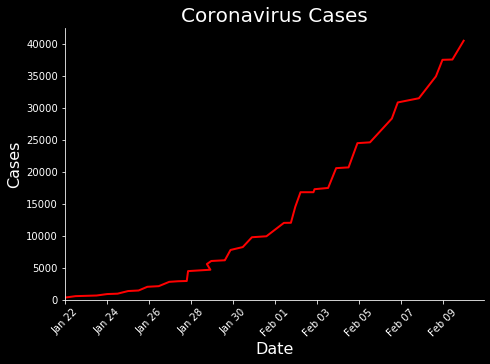

In [14]:
ax = plt.subplot()
ax.plot(corona, color='red')
ax.set_xlabel("Date")
ax.set_ylabel("Cases")
ax.set_title("Coronavirus Cases")
setTicks(ax,dates,2,True);

Scary stuff, but that's a topic for another project.

Now, let's get the stock market data for China. I will be using data from the Shanghai Stock Exchange, as that's where Google told me would be a good place to look.

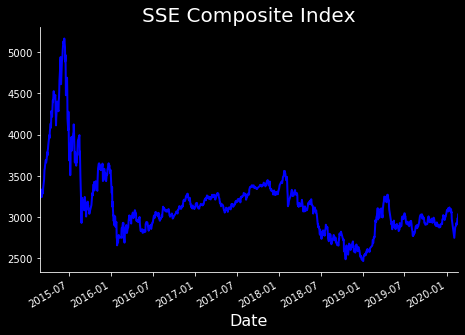

In [15]:
sse = yf.Ticker('000001.SS')
sse_data = sse.history(period='5y',actions=False)['Close']
sse_data.plot(color='blue');
plt.title("SSE Composite Index");

Zooming in on the data from this year, approximately when the outbreak started, gives us this picture:

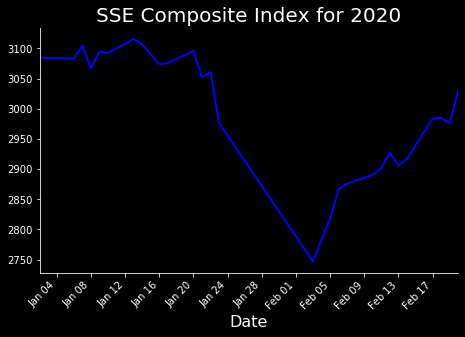

In [16]:
sse_data = sse_data["2020-01-01":]
sse_data.plot(color='blue')
plt.title("SSE Composite Index for 2020")
setTicks(plt.gca(),sse_data.index,4,False)

We can clearly see a very visible drop starting on approximately January 22 and lasting until February 3. It's important to note, however, that the drop may appear bigger than it actually is as the y-axis does not start at 0.

Now, let's see what will happen if we lay the two graphs on top of each other. To do this, I made a function that slightly repeats what we've already done, so that it is more useful in the future.

In [17]:
corrs = pd.DataFrame(columns=['Full Time','Until Feb 2nd','After Feb 2nd','Name']).set_index('Name')
def compare(stock,name):
    abb = yf.Ticker(stock)
    data = abb.history(period='max',actions=False)['Close']['2020-01-01':]

    a1 = plt.subplot(111,label=stock)
    a2 = a1.twinx()
    ln1 = a1.plot(data,label=name,color='blue')
    ln2 = a2.plot(dates,daily,color='red',label='Coronavirus')
    
    a1.set_title(name+" & Coronavirus Cases")
    a2.set_ylabel("Cases")
    a1.set_xlabel("Date")
    a2.spines['right'].set_visible(True)
    lns = ln1+ln2
    labs = [l.get_label() for l in lns]
    a1.legend(lns, labs, loc='lower left')

    setTicks(a2,data.index,4,True)
    a1.tick_params('x',labelrotation=45)
    
    s = '2020-02-02'
    corr1 = corona.corr(data.reindex(corona.index, method='nearest'))
    corr2 = corona[:s].corr(data[:s].reindex(corona[:s].index, method='nearest'))
    corr3 = corona[s:].corr(data[s:].reindex(corona[s:].index, method='nearest'))
    corrs.loc[name] = [corr1,corr2,corr3]

And now, the graph:

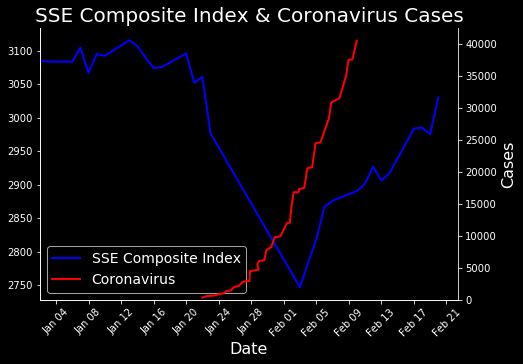

In [18]:
compare('000001.SS','SSE Composite Index')

You may have noticed that I also snuck in some code to find the correlation between the two plots. But don't worry about that for now, we'll get to it once all the data is collected.

Now let's do the same thing for the price of Crude Oil, which has dropped recently due to declining demand from China. I'm also going to make a function to do this comparison with several other economic indicators.

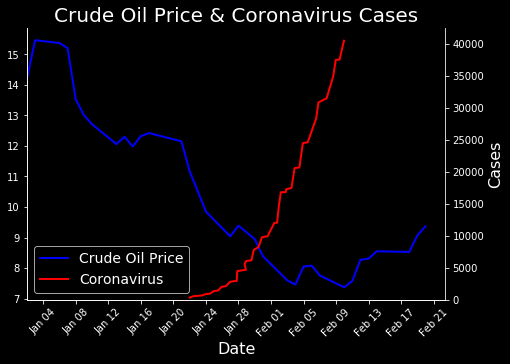

In [19]:
compare("UWT","Crude Oil Price")

Now let's do another chart, this time with the price of copper, an important material for the construction industry, which has certainly has been affected by the outbreak.

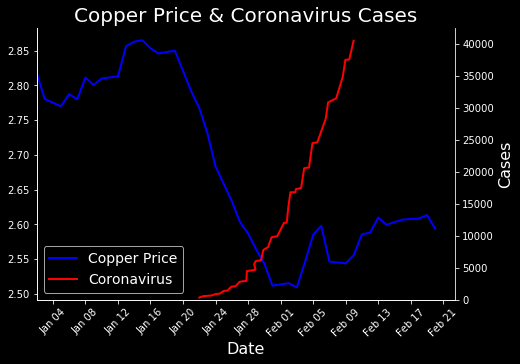

In [20]:
compare("HG=F","Copper Price")

And, of course, the S&P 500 to show impact on the U.S. economy in particular

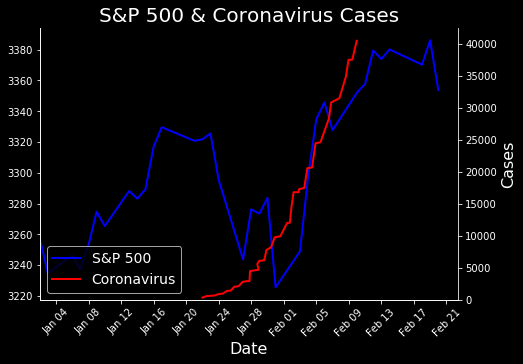

In [21]:
compare("^GSPC","S&P 500")

Now that we finally have all the data, we can add the average, and take a closer look at the correlations we found:

In [22]:
corrs.loc['Average'] = corrs.mean()
print(corrs)

                     Full Time  Until Feb 2nd  After Feb 2nd
Name                                                        
SSE Composite Index  -0.240355      -0.217161       0.930453
Crude Oil Price      -0.825579      -0.785958      -0.229257
Copper Price         -0.520545      -0.827878       0.313244
S&P 500               0.621350      -0.701546       0.860571
Average              -0.241282      -0.633136       0.468753


I chose to split the data up around Feb 2nd as that's when many of the market graphs began to rebound after their initial drop. This behavior seems to suggest that there may have been initial panic over the outbreak, but it subsided shorty after. To confirm this, let's take a more visual look at the data.

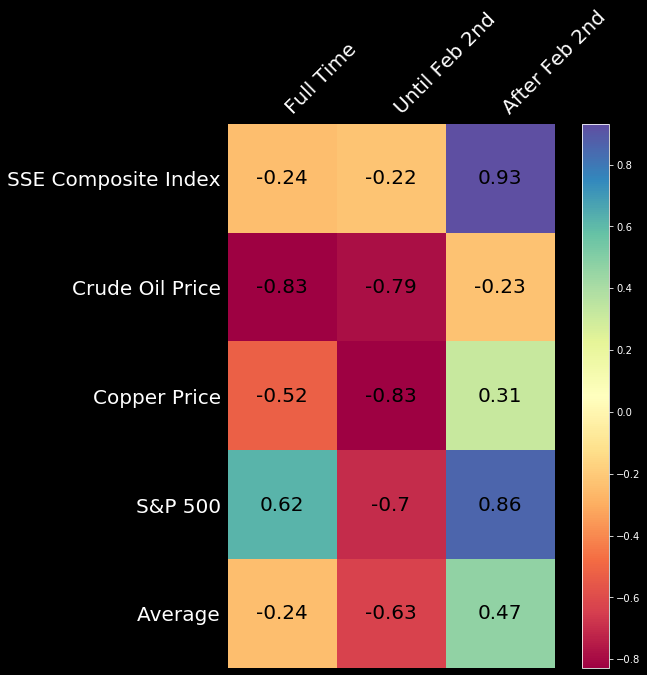

In [23]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cax = ax.matshow(corrs, interpolation='none',cmap='Spectral')
fig.colorbar(cax)
import numpy as np
for (i, j), z in np.ndenumerate(corrs):
    ax.text(j, i, round(z,2), ha='center', va='center', fontsize=20,color='black')
plt.xticks(range(len(corrs.columns)), corrs.columns,rotation=45, ha='left', fontsize=20)
plt.yticks(range(len(corrs.index)), corrs.index, fontsize = 20)
plt.tick_params(axis='x', which='both', bottom=False,top=False,) 
plt.tick_params(axis='y', which='both', right=False,left=False) 
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

While this graph may seem like simply 12 colored boxes, in reality it is the answer to all the questions we went in to this asking.

Representing the correlation between the market data and the outbreak since it began, the first column shows that the overall impact has varied depending on which dataset you look at. Overall, however, it is clear that the outbreak hurt the overall economy, but with varying severity.

Looking at the second column, almost all of the economic metrics initially had a large negative correlation with the coronavirus cases. The only excpetion to this was the SSE Composite Index, as it was closed for the majority of this time due to Lunar New Year celebrations. This suggests that news of the outbreak did in fact worry investors, who reacted quickly with their wallets in mind.

The third column, on the other hand, shows the correlation to be decently positive, suggesting that markets rebounded even as the number of diagnosed coronavirus cases continued to increase.
This supports the notion that while their may have been an initial negative reaction to the outbreak in the markets, it has since largely reversed itself.

The rows of the heatmap, meanwhile, show the differences in effects of the coronavirus on different markets. While the price of crude oil dropped and is continuing to drop, the S%P 500 has largely recovered from any drop it had. The data from the rows lines up with conventional wisdom: markets more distanced from China are less affected by the outbreak.

## Based on this data, the coronavirus did harm the worldwide economy initially, but has not noticably prevented growth afterwards.